In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Считаем два датасета

In [3]:
df1 = pd.read_parquet('source1.pq', engine='fastparquet')
df2 = pd.read_parquet('source2.pq', engine='fastparquet')

In [4]:
df1.shape, df2.shape

((219013, 15), (279732, 15))

Во 2 выборке больше сессий, нежели в 1 выборке

## Приведение к общему виду

В каждом датасете есть отличающиеся значения, приведем их к одному виду

In [11]:
import re
def fun(text):
    pattern = r'^[А-Я]{2}:\s*(.*?)\s*\('
    match = re.search(pattern, text)
    result = match.group(1)  # Извлекаем первую группу
    return result

In [12]:
df1.loc[df1['channel'].notnull(), 'channel'] = df1.loc[df1['channel'].notnull(), 'channel'].apply(fun)

In [13]:
df2['age'] = df2['age'].astype(int)

In [14]:
df2['educ'].unique()

array(['среднее', 'высшее'], dtype=object)

In [15]:
df2['educ'] = df2['educ'].map({'среднее':'medium','высшее':'high'})

In [16]:
df2['famSize'].unique()

array(['2 человека в семье', '4+ человека в семье', '3 человека в семье',
       '1 человек в семье'], dtype=object)

In [17]:
df2['famSize'] = df2['famSize'].map({'2 человека в семье':'1-2 persons','4+ человека в семье':'4+ persons',
                                     '3 человека в семье':'3 persons','1 человек в семье':'1-2 persons'})

In [18]:
df1['occupation'].unique()

array(['other unemployed', 'manager', 'workers', 'employees',
       'specialists', 'housewives', 'NA', 'students'], dtype=object)

In [19]:
df2['occupation'].unique()

array(['рабочие', 'служащие', 'специалисты', 'др. неработающие',
       'учащиеся', 'руководители', 'домохозяйки'], dtype=object)

In [20]:
df2['occupation'] = df2['occupation'].map({'рабочие':'workers', 'служащие':'employees', 'специалисты':'specialists', 'др. неработающие':'other unemployed',
       'учащиеся':'students', 'руководители':'manager', 'домохозяйки':'housewives'})

In [21]:
df2['sex'] = df2['sex'].map({'Женщины':'female','Мужчины':'male'})

In [22]:
df2['work'] = df2['work'].map({'не работает':'no','работает':'yes'})

In [23]:
df2.sample(5)

,date,id,Population,age,educ,famSize,occupation,sex,work,ageGroup,tvStartTime,tvEndTime,duration,productid,channel
257048,2023-02-25,174,3.446577,41,high,3 persons,other unemployed,female,yes,35-44,2023-02-25 08:04:00,2023-02-25 08:09:59,359.0,12319.0,OTHER TV SET
101271,2023-02-26,93,12.498525,70,medium,1-2 persons,other unemployed,female,no,65+,2023-02-26 14:59:00,2023-02-26 14:59:59,59.0,11003.0,Измеряемое локальное ТВ
54582,2023-02-28,35,4.828878,69,medium,1-2 persons,employees,female,yes,65+,2023-02-28 20:10:00,2023-02-28 20:11:59,119.0,1869.0,ДОМАШНИЙ
137106,2023-02-23,727,2.140580,36,high,1-2 persons,specialists,male,yes,35-44,2023-02-23 19:05:00,2023-02-23 19:07:59,179.0,1875.0,ЗВЕЗДА
97399,2023-02-26,227,2.505865,65,high,1-2 persons,other unemployed,female,no,65+,2023-02-26 13:53:00,2023-02-26 13:53:59,59.0,11003.0,Измеряемое локальное ТВ


In [24]:
df2["day"] = df2["tvStartTime"].dt.to_period("D")
df1["day"] = df1["tvStartTime"].dt.to_period("D")

In [25]:
day = '2023-02-21'
df2[(df2['day'] == day)].head(5)

,date,id,Population,age,educ,famSize,occupation,sex,work,ageGroup,tvStartTime,tvEndTime,duration,productid,channel,day
0,2023-02-22,1705,5.414112,46,medium,1-2 persons,workers,female,yes,45-54,2023-02-21 21:00:00,2023-02-21 23:28:59,8939.0,12319.0,OTHER TV SET,2023-02-21
1208,2023-02-22,1248,3.692860,55,high,1-2 persons,manager,male,yes,55-64,2023-02-21 21:00:00,2023-02-21 21:09:59,599.0,12319.0,OTHER TV SET,2023-02-21
1209,2023-02-22,1248,3.692860,55,high,1-2 persons,manager,male,yes,55-64,2023-02-21 21:11:00,2023-02-21 22:03:59,3179.0,12319.0,OTHER TV SET,2023-02-21
2723,2023-02-22,277,5.796297,76,high,1-2 persons,other unemployed,female,no,65+,2023-02-21 22:00:00,2023-02-21 22:13:59,839.0,1872.0,ТВ-3,2023-02-21
2724,2023-02-22,277,5.796297,76,high,1-2 persons,other unemployed,female,no,65+,2023-02-21 22:14:00,2023-02-21 23:38:59,5099.0,11003.0,Измеряемое локальное ТВ,2023-02-21


Выше видно, что есть данные и по 21 число (в полях tvStartTime и tvEndTime), хотя они относятся к 22 числу (по полю date), скорее всего это является ошибкой, удалим их

In [27]:
df2[(df2['day'] == day)].shape

(2287, 16)

In [28]:
ind = df2[(df2['day'] == day)].index
df2.drop(ind, inplace=True)

Посмотрим на пропуски в данных

## Изучение числовых признаков

In [31]:
from pandas.api.types import is_numeric_dtype

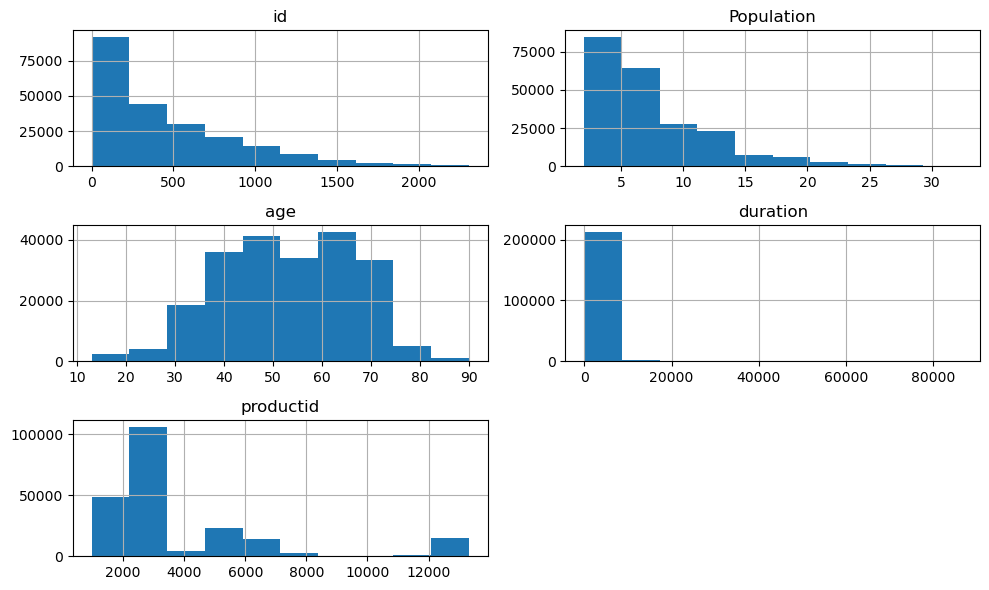

In [32]:
num_cols = [x for x in df1.columns if is_numeric_dtype(df1[x])]
df1[num_cols].hist(figsize=(10,6))
plt.tight_layout()
plt.show()

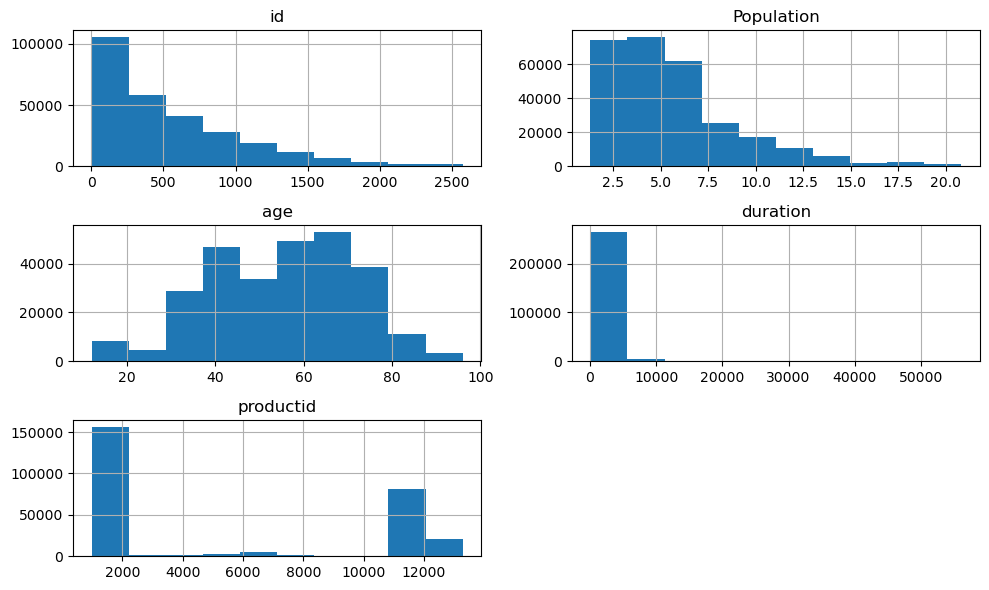

In [33]:
df2[num_cols].hist(figsize=(10,6))
plt.tight_layout()
plt.show()

Во 2 выборке больше респодентов, имещих больший вес по сравнению с 1 выборкой

Изучим выбросы в призаке duration в df1

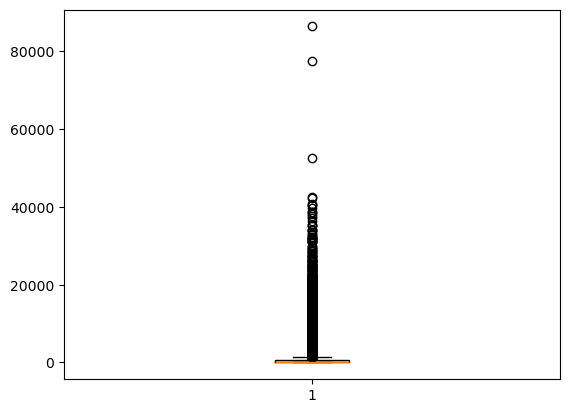

In [35]:
plt.boxplot(df1[~df1['duration'].isna()]['duration'])
plt.show()

In [36]:
df1[df1['duration']>43200].shape

(3, 16)

Будем предполагать, что продолжительность просмотра более 12 часов - неинформативные данные, поскольку вряд ли человек будет смотреть телевизор более 12 часов не отрываясь, потому удалим эти образцы

In [39]:
index = df1[df1['duration']>43200].index
df1.drop(index, inplace=True)

In [40]:
index = df2[df2['duration']>43200].index
df2.drop(index, inplace=True)

Проверим корреляцию числовых признаков

## Изучение категориальных данных

In [43]:
cat_col = ['educ','famSize','occupation','sex','work','ageGroup']

Выведем частоту появление категориальных признаках в образцах. 1 столбец - 1 выборка, 2 столбец - 2 выборка.

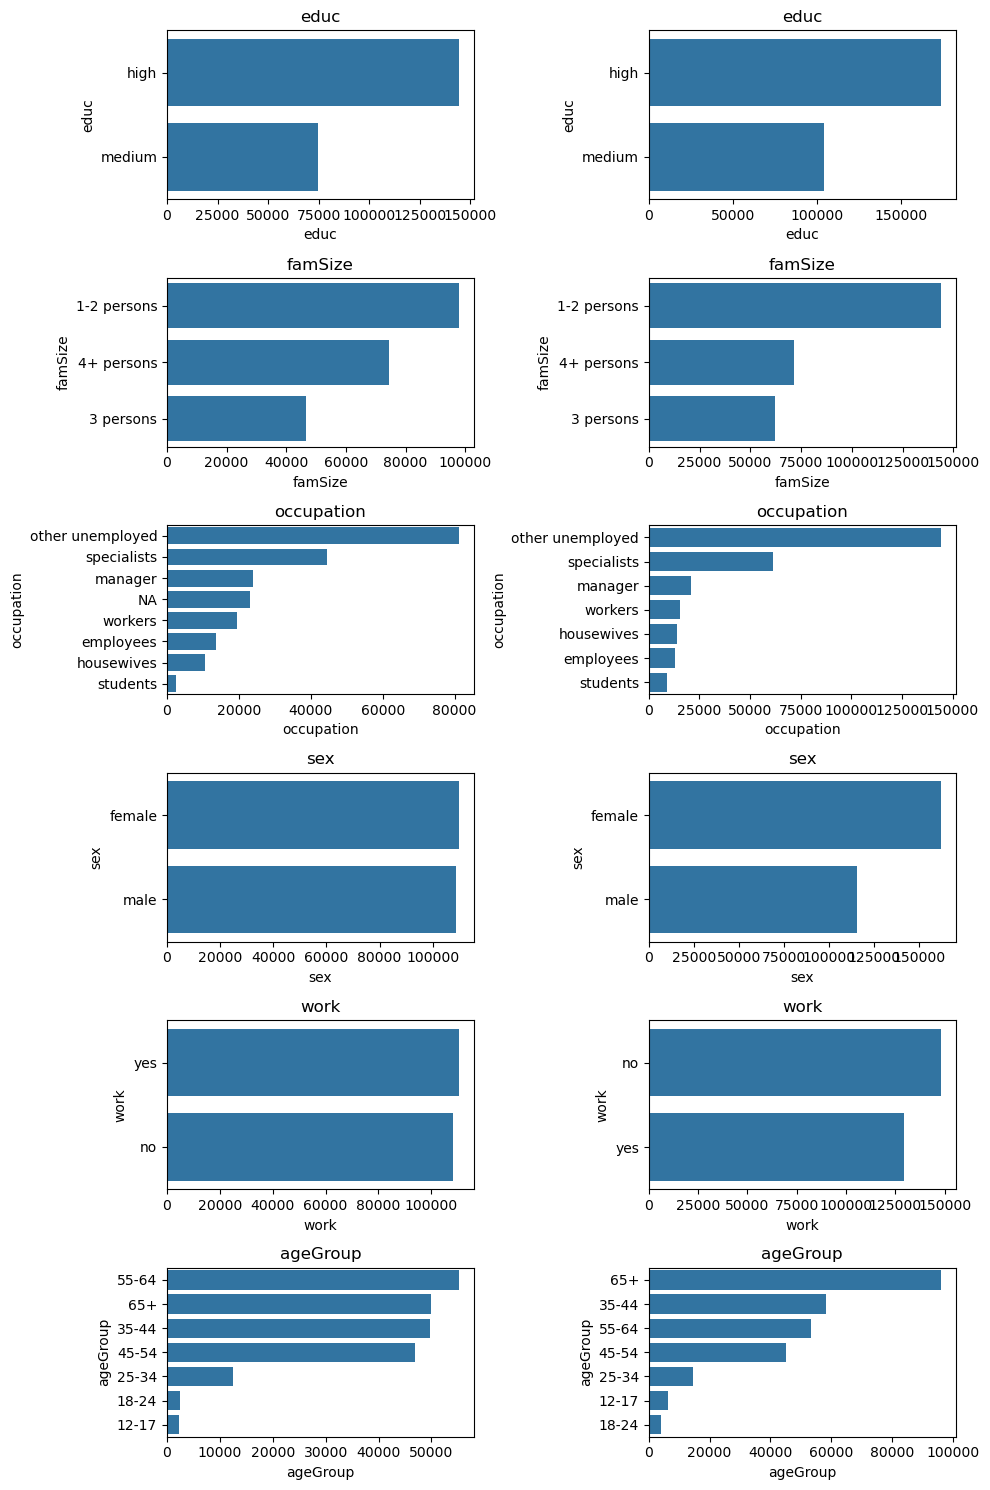

In [383]:
plt.figure(figsize=(10,15))
plotnumber = 1
for cat_feature in cat_col:
    ax = plt.subplot(6,2,plotnumber)
    sns.countplot(y=cat_feature,data=df1, order=df1[cat_feature].value_counts().index)
    plt.xlabel(cat_feature)
    plt.title(cat_feature)
    plt.tight_layout()
    plotnumber+=1
    ax = plt.subplot(6,2,plotnumber)
    sns.countplot(y=cat_feature,data=df2, order=df2[cat_feature].value_counts().index)
    plt.xlabel(cat_feature)
    plt.title(cat_feature)
    plt.tight_layout()
    plotnumber+=1
plt.show()

Выводы:

- В 1 выбоке респоденты в группе "4+ person" активнее, чем в 2 выборке (производят больше сессий).
- Во 2 выборке женщины провели больше сессий
- Во 2 выборке респоденты 65+ провели больше сессий, чем в 1 выборке

Выведем соотношение значений каждого категориального признака у уникальных пользователей (в каждом id респондента может быть несколько уникальных пользователей). 1 столбец - 1 выборка, 2 столбец - 2 выборка.

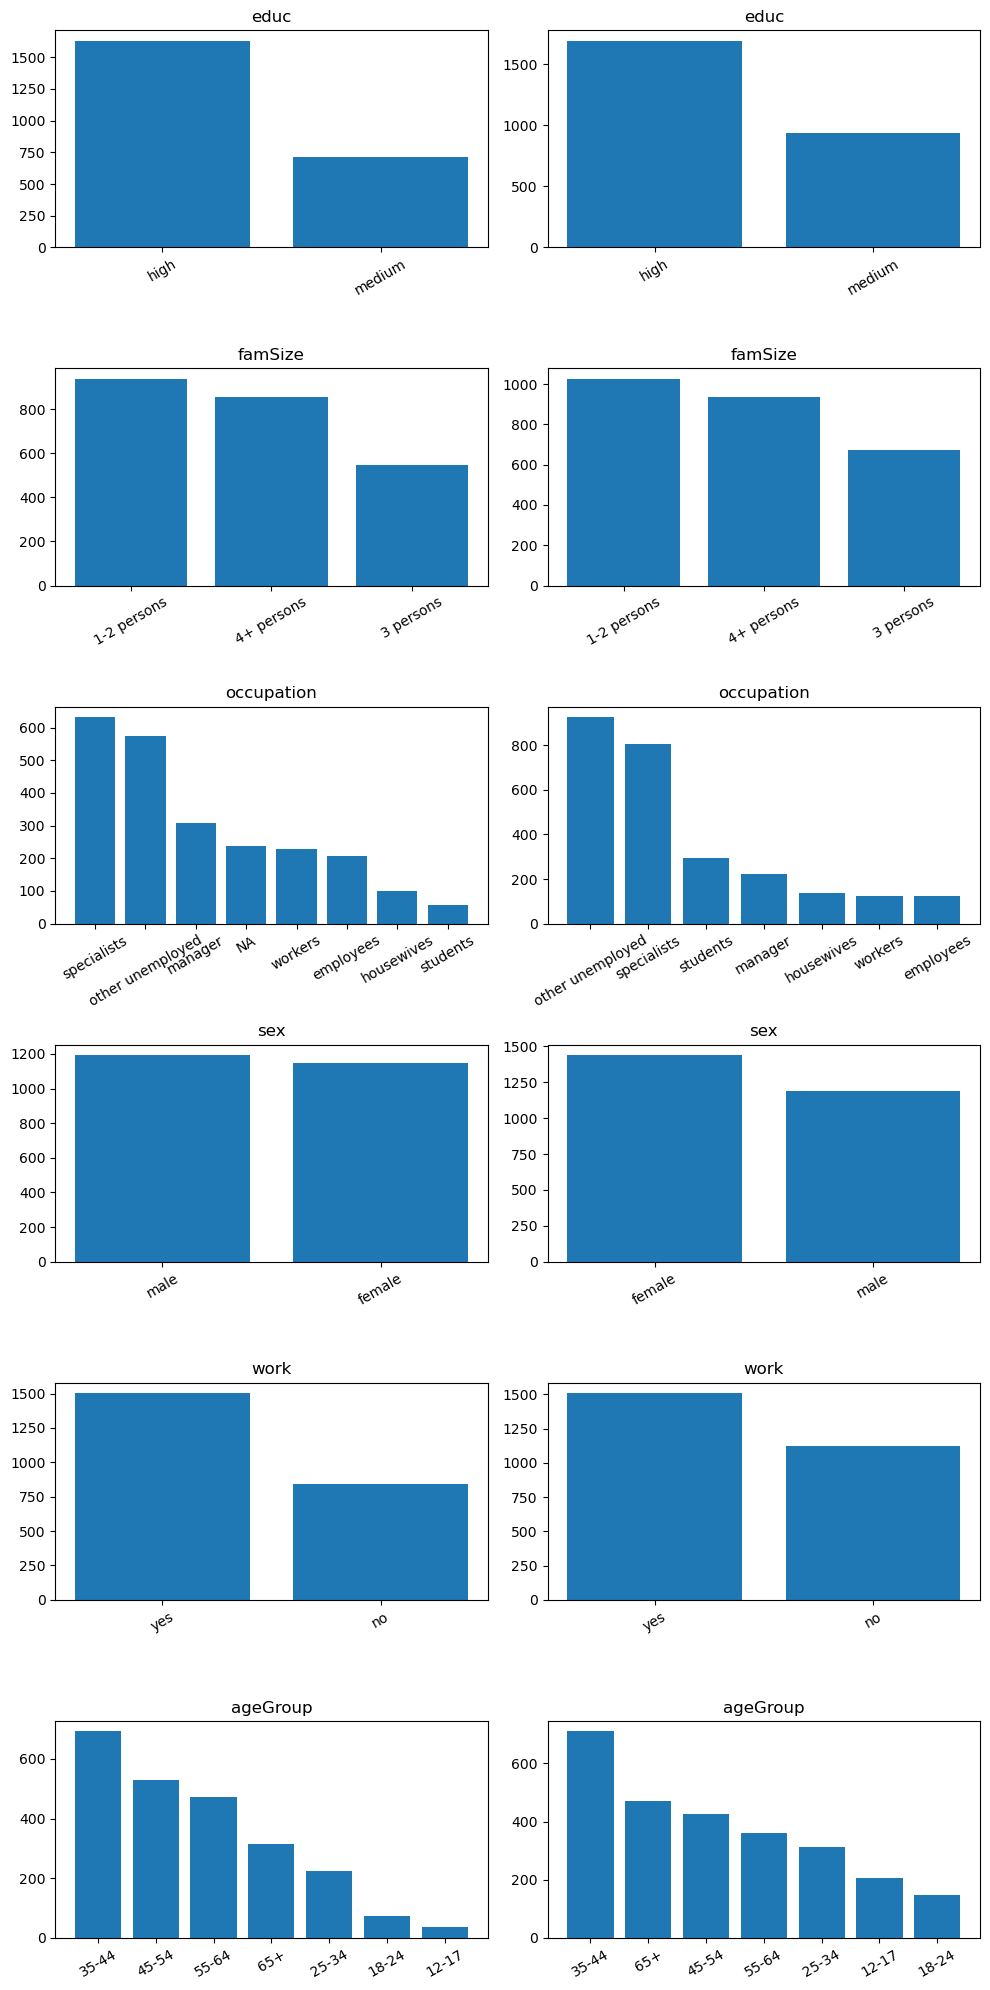

In [387]:
plt.figure(figsize=(10,20))
plotnumber = 1
for cat_feature in cat_col:
    data1 = pd.DataFrame(df1.drop_duplicates(subset=['id','age','sex','occupation','work'])[cat_feature].value_counts(), columns=['count']).reset_index()
    data2 = pd.DataFrame(df2.drop_duplicates(subset=['id','age','sex','occupation','work'])[cat_feature].value_counts(), columns=['count']).reset_index()

    ax = plt.subplot(6,2,plotnumber)
    ax.bar(data1[cat_feature],data1['count'])
    plt.title(cat_feature)
    plt.xticks(rotation = 30) 
    plt.tight_layout()
    plotnumber += 1
    ax = plt.subplot(6,2,plotnumber)
    ax.bar(data2[cat_feature],data2['count'])
    plt.title(cat_feature)
    plt.xticks(rotation = 30) 
    plt.tight_layout()
    plotnumber += 1

Эти долевые соотношения коррелируют с предыдущими графиками по всем сессиям:

- Долевое соотношение уникальных пользователей по признаку famSize В 1 и 2 выборке одинаковы, но респоденты 1 выборки в группе "4+ person" действительно чаще смотрели ТВ, чем в 2 выборке.
- Во 2 выборке женщины провели больше сессий, поскольку по долевому соотношению уникальных пользователей их больше
- По долевому соотношению во 2 выборке людей с возрастом +65 больше, чем в 1 выборке.

## Проверка гипотезы

Распределение признака duration ненормально, поэтому мы можем использовать только непараметрические критерии. Но критерий Манна-Уитни для такой большой выборки будет плох, поэтому воспользуемся бутстреп методом. Уровень доверия 0.95.
- H0: Среднее duration не отличается в двух выборках
- H1: Среднее duration отличается в двух выборках

In [340]:
def bootstrap_diff_means(sample1, sample2, num_samples):
    n1 = len(sample1)
    n2 = len(sample2)
    diffs = np.empty(num_samples)
    
    for i in range(num_samples):
        sample1_bootstrap = np.random.choice(sample1, size=n1, replace=True)
        sample2_bootstrap = np.random.choice(sample2, size=n2, replace=True)
        diffs[i] = np.mean(sample1_bootstrap) - np.mean(sample2_bootstrap)
    
    return diffs


num_samples = 10000 


bootstrap_diffs = bootstrap_diff_means(df1['duration'].dropna(axis=0), df2['duration'].dropna(axis=0), num_samples)


observed_diff = np.mean(df1['duration'].dropna(axis=0)) - np.mean(df2['duration'].dropna(axis=0))


p_value = np.mean(np.abs(bootstrap_diffs) >= np.abs(observed_diff))

In [341]:
p_value

0.4993

Мы не можем отклонить гипотезу о том, что среднее значение признака duration в двух выборок различается

## Метрики по каналу "Звезда"

Будем изучать основные метрики на канале "Звезда"

In [62]:
print(df1[df1['channel'] == 'ЗВЕЗДА'].shape)

(5414, 16)


In [96]:
days = np.array([str(x) for x in df1['day'].unique()])
days = np.delete(np.array(days), 7)
daily_reach1 = {}
daily_reach2 = {}
for day in days:
    day_reach1 = df1[(df1['channel'] == 'ЗВЕЗДА') & (df1['day'] == day)].drop_duplicates(subset=['id'])['Population'].sum()
    day_reach2 = df2[(df2['channel'] == 'ЗВЕЗДА') & (df2['day'] == day)].drop_duplicates(subset=['id'])['Population'].sum()
    daily_reach2[day] = day_reach1
    daily_reach1[day] = day_reach2

In [98]:
#print(*sorted(daily_reach.items()),sep='\n')

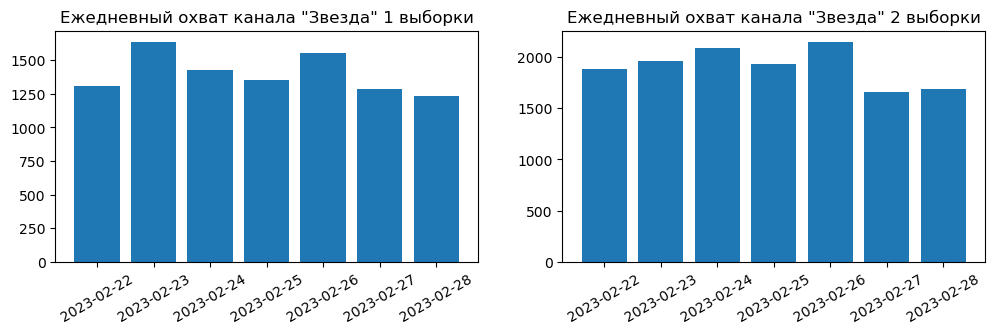

In [104]:
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.bar(*zip(*daily_reach1.items()))
plt.xticks(rotation = 30)
plt.title('Ежедневный охват канала "Звезда" 1 выборки')
plt.subplot(1,2,2)
plt.bar(*zip(*daily_reach2.items()))
plt.xticks(rotation = 30)
plt.title('Ежедневный охват канала "Звезда" 2 выборки')
plt.show()

Общая тенденция в двух выборках - ежедневный охват канала "Звезда" уменьшается

In [115]:
weekly_reach1 = df1[df1['channel'] == 'ЗВЕЗДА'].drop_duplicates(subset=['id','day'])['Population'].mean() / 7

In [117]:
weekly_reach2 = df2[df2['channel'] == 'ЗВЕЗДА'].drop_duplicates(subset=['id','day'])['Population'].mean() / 7

In [119]:
weekly_reach1, weekly_reach2

(1.0454041547084059, 0.8025219574868938)

In [ ]:
print('Cумма средних весов респондентов за период, которые хотя бы один раз смотрели канал "Звезда" с 22 по 28 число:\n',weekly_reach)

In [161]:
average_viewing1 = {}
average_viewing2 = {}
for day in days: 
    
    sum_multiplications1 = df1[(df1['channel'] == 'ЗВЕЗДА')&(df1['day'] == day)].apply(
        lambda x: x['duration']* x['Population'], axis=1).sum()
    sum_multiplications2 = df2[(df2['channel'] == 'ЗВЕЗДА')&(df2['day'] == day)].apply(
        lambda x: x['duration']* x['Population'], axis=1).sum()

    sum_weights1 =  df1[(df1['channel'] == 'ЗВЕЗДА')&(df1['day'] == day)]['Population'].sum()
    average_viewing1[day] = sum_multiplications1 /  sum_weights1 
    sum_weights2 =  df2[(df2['channel'] == 'ЗВЕЗДА')&(df2['day'] == day)]['Population'].sum()
    average_viewing2[day] = sum_multiplications2 /  sum_weights2
    # print('Day = ',day,'sum_multiplications1 = ',sum_multiplications1)
    # print('Day = ',day,'sum_weights1 = ',sum_weights1)
    # print('\n')

In [162]:
#print(*sorted(average_viewing1.items()),sep='\n')

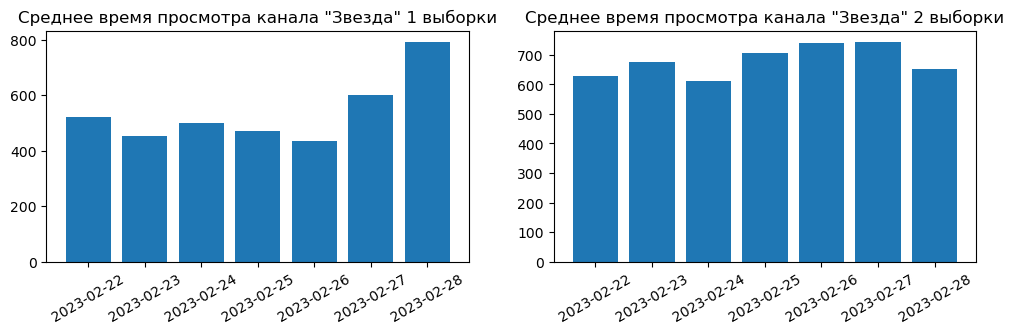

In [128]:
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.bar(*zip(*average_viewing1.items()))
plt.xticks(rotation = 30)
plt.title('Среднее время просмотра канала "Звезда" 1 выборки')
plt.subplot(1,2,2)
plt.bar(*zip(*average_viewing2.items()))
plt.xticks(rotation = 30)
plt.title('Среднее время просмотра канала "Звезда" 2 выборки')
plt.show()

Заметно, что среднее время просмотра во 2 выборке распределено практически равномерно, а в 1 выборке среднее время просмотра 27 и 28 числа резко возросло по сравнению с остальными днями

Посмотрим сессии просмотров для этих дней (27.02 и 28.02) для 1 выборки по убыванию продолжительности просмотра

In [207]:
df1[((df1['day'] == '2023-02-27' )| (df1['day'] =='2023-02-28')) & (df1['channel'] == 'ЗВЕЗДА')].sort_values(by=['duration'], ascending=False).head(5)

,date,id,Population,age,educ,famSize,occupation,sex,work,ageGroup,tvStartTime,tvEndTime,duration,productid,channel,day
214007,2023-02-28,520,7.788645,59,high,3 persons,other unemployed,female,no,55-64,2023-02-28 18:49:22,2023-02-28 23:23:28,16446.0,3324.0,ЗВЕЗДА,2023-02-28
214001,2023-02-28,520,7.788645,59,high,3 persons,other unemployed,female,no,55-64,2023-02-28 10:48:43,2023-02-28 14:55:38,14815.0,3324.0,ЗВЕЗДА,2023-02-28
36186,2023-02-28,168,3.942868,43,high,4+ persons,other unemployed,female,no,35-44,2023-02-28 10:22:41,2023-02-28 13:51:32,12531.0,3324.0,ЗВЕЗДА,2023-02-28
36510,2023-02-28,907,18.712693,62,medium,4+ persons,employees,female,yes,55-64,2023-02-28 14:51:16,2023-02-28 18:11:16,12000.0,3324.0,ЗВЕЗДА,2023-02-28
8415,2023-02-27,159,12.684935,70,medium,1-2 persons,other unemployed,female,no,65+,2023-02-27 19:39:42,2023-02-27 22:42:00,10938.0,3324.0,ЗВЕЗДА,2023-02-27


Те же дни, но для 2 выборки

In [209]:
df2[((df2['day'] == '2023-02-27' )| (df2['day'] =='2023-02-28')) & (df2['channel'] == 'ЗВЕЗДА')].sort_values(by=['duration'], ascending=False).head(5)

,date,id,Population,age,educ,famSize,occupation,sex,work,ageGroup,tvStartTime,tvEndTime,duration,productid,channel,day
75112,2023-02-28,1330,2.846350,46,high,1-2 persons,other unemployed,male,yes,45-54,2023-02-28 17:24:00,2023-02-28 18:48:59,5099.0,1875.0,ЗВЕЗДА,2023-02-28
194922,2023-02-27,187,10.851021,70,medium,1-2 persons,other unemployed,female,no,65+,2023-02-27 17:21:00,2023-02-27 18:43:59,4979.0,1875.0,ЗВЕЗДА,2023-02-27
65317,2023-02-27,210,6.233514,64,medium,1-2 persons,workers,male,yes,55-64,2023-02-27 17:25:00,2023-02-27 18:43:59,4739.0,1875.0,ЗВЕЗДА,2023-02-27
126164,2023-02-27,924,2.070809,59,high,1-2 persons,other unemployed,male,no,55-64,2023-02-27 17:25:00,2023-02-27 18:43:59,4739.0,1875.0,ЗВЕЗДА,2023-02-27
197656,2023-02-28,84,2.846407,78,high,1-2 persons,other unemployed,male,no,65+,2023-02-28 04:00:00,2023-02-28 05:18:59,4739.0,1875.0,ЗВЕЗДА,2023-02-28


Можем заметить, что есть респоденты, которые намного дольше просматривали этот телеканал в 1 выборке, чем во 2 выборке (16 тысяч против 5 тысяч секунд)
К тому же можем заметить, что целевая аудитория этого канала по возрасту - люди 55-64, +65.

Для 1 выборки и телеканала "Звезда":

In [198]:
df1[df1['channel'] == 'ЗВЕЗДА'].groupby('ageGroup').size().reset_index().sort_values(by=[0], ascending=False)

,ageGroup,0
5,55-64,1633
6,65+,1569
4,45-54,1069
3,35-44,831
2,25-34,217
0,12-17,70
1,18-24,25


Для 2 выборки и телеканала "Звезда":

In [201]:
df2[df2['channel'] == 'ЗВЕЗДА'].groupby('ageGroup').size().reset_index().sort_values(by=[0], ascending=False)

,ageGroup,0
6,65+,2348
5,55-64,1108
4,45-54,715
3,35-44,545
2,25-34,99
1,18-24,44
0,12-17,28


## Изучение общих тенденций

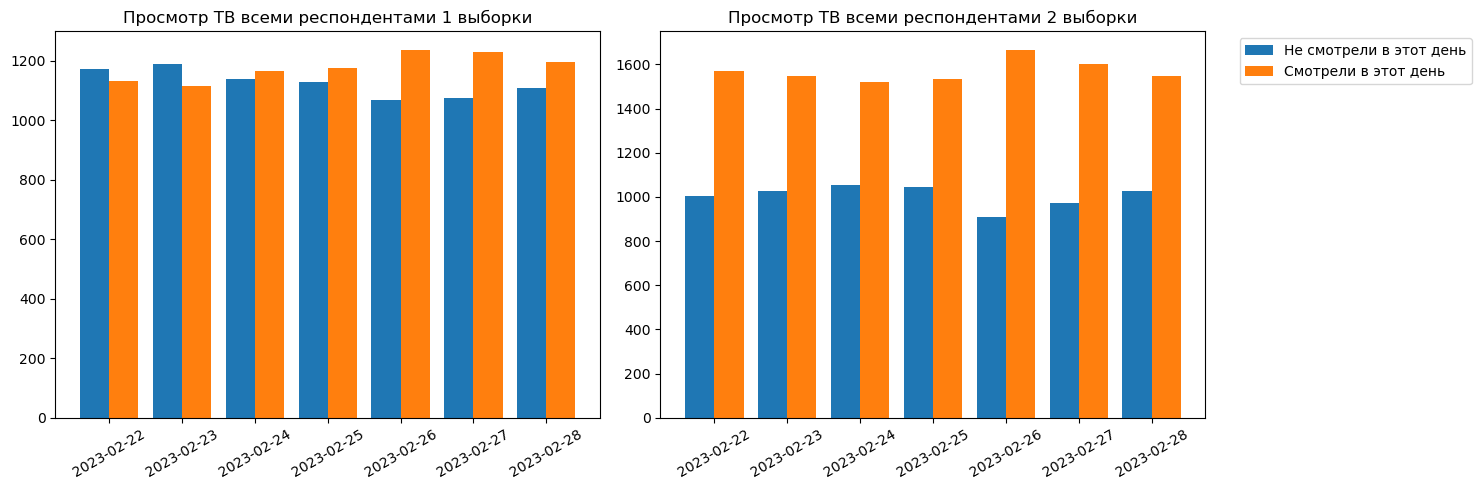

In [289]:
plt.figure(figsize=(15,5))
count_respondent1 = df1['id'].unique().shape[0]
data = df1[df1['day'].notnull()].drop_duplicates(subset=['id','day']).groupby('day').agg({'date':'count'})
plt.subplot(1,2,1)
n_ticks = np.arange(len(data['date']))
offset = 0.2
w = 0.4
plt.bar(n_ticks - offset, count_respondent1 - data['date'], width=w)
plt.bar(n_ticks + offset, data['date'], width=w)

plt.title('Просмотр ТВ всеми респондентами 1 выборки')
#plt.legend(['Не смотрели в этот день', 'Смотрели в этот день'],loc='upper left',bbox_to_anchor=(1.05, 1.0))
plt.xticks(n_ticks, data.index, rotation = 30) 
plt.tight_layout()

plt.subplot(1,2,2)
count_respondent2 = df2['id'].unique().shape[0]

data = df2[df2['day'].notnull()].drop_duplicates(subset=['id','day']).groupby('day').agg({'date':'count'})
n_ticks = np.arange(len(data['date']))
plt.bar(n_ticks - offset, count_respondent2 - data['date'], width=w)
plt.bar(n_ticks + offset, data['date'], width=w)
plt.title('Просмотр ТВ всеми респондентами 2 выборки')
plt.legend(['Не смотрели в этот день', 'Смотрели в этот день'],loc='upper left',bbox_to_anchor=(1.05, 1.0))
plt.xticks(n_ticks, data.index, rotation = 30) 
plt.tight_layout()
plotnumber += 1

In [401]:
print('Размер 1 выборки = ',df1.shape[0],', число уникальных респодентов 1 выборки= ',count_respondent1)
print('Размер 2 выборки = ',df2.shape[0],', число уникальных респодентов 2 выборки= ',count_respondent2)
print('Отношение размера выборки к числу уникальных респодентов 1 выборки = ',df1.shape[0] / count_respondent1)
print('Отношение размера выборки к числу уникальных респодентов 2 выборки = ',df2.shape[0] / count_respondent2)

Размер 1 выборки =  219010 , число уникальных респодентов 1 выборки=  2304
Размер 2 выборки =  277422 , число уникальных респодентов 2 выборки=  2575
Отношение размера выборки к числу уникальных респодентов 1 выборки =  95.05642361111111
Отношение размера выборки к числу уникальных респодентов 2 выборки =  107.73669902912621


По графику выше и небольших вычислениям видно, что в среднем во 2 выборки люди чаще смотрят ТВ. Каждый респодент в среднем за этот период совершил 108 сессий в 2 выборке, по сравнению с 1 выборкой, где этот показатель равен 95.
Также можно сказать, что самый популярный день просмотра ТВ - 26.02 - воскресенье для обоих выборок.

In [304]:
average_viewing_all1 = {}
average_viewing_all2 = {}
for day in days: 
    
    sum_multiplications1 = df1[(df1['day'] == day)].apply(
        lambda x: x['duration']* x['Population'], axis=1).sum()
    sum_multiplications2 = df2[(df2['day'] == day)].apply(
        lambda x: x['duration']* x['Population'], axis=1).sum()
    sum_weights1 =  df1[(df1['day'] == day)]['Population'].sum()
    sum_weights2 =  df2[(df2['day'] == day)]['Population'].sum()    
    average_viewing_all2[day] = sum_multiplications2 /  sum_weights2
    average_viewing_all1[day] = sum_multiplications1 /  sum_weights1

In [ ]:
#print(*sorted(average_viewing_all.items()),sep='\n')

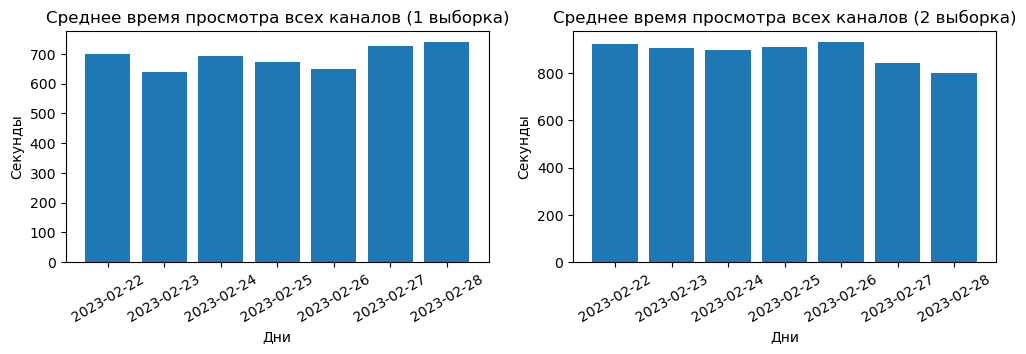

In [314]:
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.bar(*zip(*average_viewing_all1.items()))
plt.xticks(rotation = 30)
plt.title('Среднее время просмотра всех каналов (1 выборка)')
plt.xlabel('Дни')
plt.ylabel('Секунды')
plt.subplot(1,2,2)
plt.bar(*zip(*average_viewing_all2.items()))
plt.xticks(rotation = 30)
plt.title('Среднее время просмотра всех каналов (2 выборка)')
plt.xlabel('Дни')
plt.ylabel('Секунды')
plt.show()

Почти все время среднее время просмотра сильно не изменялась в обоих выборках. Однако почему 27 и 28 числа в 1 выборке среднее время увеличилось, а в 2 выборке наоборот уменьшилось?

Посмотрим сессии 27 и 28 числа в обоих выборках в убывании по продолижительности просмотра

In [324]:
df1[((df1['day'] == '2023-02-27' )| (df1['day'] =='2023-02-28'))].sort_values(by=['duration'], ascending=False).head(7)

,date,id,Population,age,educ,famSize,occupation,sex,work,ageGroup,tvStartTime,tvEndTime,duration,productid,channel,day
16693,2023-02-27,40,6.074852,63,high,4+ persons,manager,male,yes,55-64,2023-02-27 00:00:00,2023-02-27 10:26:17,37577.0,3322.0,РЕН ТВ,2023-02-27
68029,2023-02-27,75,20.403446,58,medium,4+ persons,workers,female,yes,55-64,2023-02-27 11:18:22,2023-02-27 21:38:42,37220.0,3308.0,РОССИЯ 1,2023-02-27
175559,2023-02-27,1227,10.804888,61,medium,1-2 persons,NA,male,yes,55-64,2023-02-27 00:00:00,2023-02-27 09:19:10,33550.0,6918.0,МИР,2023-02-27
175568,2023-02-27,1227,10.804888,61,medium,1-2 persons,NA,male,yes,55-64,2023-02-27 15:05:23,2023-02-28 00:00:00,32077.0,3308.0,РОССИЯ 1,2023-02-27
208680,2023-02-28,951,5.625351,45,high,3 persons,specialists,female,yes,45-54,2023-02-28 00:00:00,2023-02-28 08:13:09,29589.0,3308.0,РОССИЯ 1,2023-02-28
67732,2023-02-27,28,3.776769,71,high,1-2 persons,workers,male,no,65+,2023-02-27 15:52:53,2023-02-28 00:00:00,29227.0,3325.0,ПЯТЫЙ КАНАЛ,2023-02-27
101967,2023-02-28,787,13.535694,30,medium,1-2 persons,NA,male,yes,25-34,2023-02-28 01:12:06,2023-02-28 09:09:29,28643.0,3323.0,Ю,2023-02-28


In [326]:
df2[((df2['day'] == '2023-02-27' )| (df2['day'] =='2023-02-28'))].sort_values(by=['duration'], ascending=False).head(7)

,date,id,Population,age,educ,famSize,occupation,sex,work,ageGroup,tvStartTime,tvEndTime,duration,productid,channel,day
88871,2023-02-28,182,2.462615,39,high,3 persons,housewives,female,no,35-44,2023-02-28 03:26:00,2023-02-28 15:20:59,42899.0,11000.0,Измеряемое тематическое ТВ,2023-02-28
88817,2023-02-27,182,2.429716,39,high,3 persons,housewives,female,no,35-44,2023-02-27 05:23:00,2023-02-27 16:28:59,39959.0,11000.0,Измеряемое тематическое ТВ,2023-02-27
109686,2023-02-27,1875,9.808223,32,medium,4+ persons,specialists,male,yes,25-34,2023-02-27 10:14:00,2023-02-27 21:00:00,38760.0,12319.0,OTHER TV SET,2023-02-27
176123,2023-02-27,1544,5.231425,27,high,1-2 persons,specialists,male,yes,25-34,2023-02-27 11:23:00,2023-02-27 20:46:59,33839.0,12319.0,OTHER TV SET,2023-02-27
47069,2023-02-28,1571,4.644589,37,high,3 persons,other unemployed,male,yes,35-44,2023-02-28 07:55:00,2023-02-28 17:16:59,33719.0,12319.0,OTHER TV SET,2023-02-28
89402,2023-02-27,929,2.960448,35,high,4+ persons,employees,female,yes,35-44,2023-02-27 06:36:00,2023-02-27 15:31:59,32159.0,12319.0,OTHER TV SET,2023-02-27
136561,2023-02-28,138,2.588860,37,high,1-2 persons,specialists,male,yes,35-44,2023-02-28 08:17:00,2023-02-28 16:56:59,31199.0,11000.0,Измеряемое тематическое ТВ,2023-02-28


В 1 выборке респоденты с наибольшей продолжительностью просмотра имеют больший вес по сравнению со 2 выборкой, поэтому появляются такие различия в метрике среднего времени просмотра.